<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/fineTuning_of_DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DETRのファインチューニング

In [1]:
# まず、使用するライブラリを呼び出す。
from google.colab import drive
import os
import shutil
import cv2
import numpy as np

In [2]:
# Google Driveを呼び出す。
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# xpFilesAnnotationのコピーを作成する。
shutil.copytree('/content/drive/MyDrive/xpFilesAnnotation','/content/xpFilesAnnotation_copy')

'/content/xpFilesAnnotation_copy'

In [4]:
#PyTorchとそのビジョン関連のライブラリ（TorchVision）をインポート
import torch, torchvision
#現在使用しているPyTorchのバージョンと、CUDAが利用可能かどうかを表示
print(torch.__version__, torch.cuda.is_available())
#勾配計算を無効化（False）。通常、モデルを評価モードで使用するときに行う。勾配計算を無効にすることで、推論が速くなり、メモリ使用量も減少
torch.set_grad_enabled(False);

2.0.1+cu118 True


#####DETRの入力と出力に対する前処理と後処理

In [5]:
#画像データの前処理（リサイズ、正規化など）のため、TorchVisionライブラリのtransformsモジュールをTという名前でインポート
import torchvision.transforms as T
#複数の画像変換を組み合わせて一つの変換を作る
transform = T.Compose([
    T.Resize(800),#画像の短い辺を800ピクセルにリサイズ
    T.ToTensor(),#PILイメージまたはNumPy ndarrayをPyTorchのテンソルに変換
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#画像の各色チャンネルを平均と標準偏差で正規化
])
#バウンディングボックスの形式を(cx, cy, w, h)から(x_min, y_min, x_max, y_max)に変換する関数を定義
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)#入力テンソルxから中心の座標(cx, cy)と幅・高さ(w, h)を抽出
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]#新しい座標形式に変換する計算
    return torch.stack(b, dim=1)#計算された座標をテンソルとしてスタック
#出力されたバウンディングボックスを画像の実際のサイズにリスケールする関数を定義
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size#画像の実際の幅と高さを抽出
    b = box_cxcywh_to_xyxy(out_bbox)#先に定義したbox_cxcywh_to_xyxy関数を用いて、バウンディングボックスの座標形式を変換
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)#バウンディングボックスの座標を画像の実際のサイズにスケーリング
    return b#スケーリングされたバウンディングボックスの座標を返している

#####モデル（おそらくDETR）からの出力をフィルタリングし、その結果を返す関数を定義
信頼度が閾値以上のバウンディングボックスと、それに対応するクラスの確率を返している。

In [6]:
#モデルの出力と信頼度の閾値(デフォルトでは0.7)を引数とする関数を定義
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  #モデル出力から'pred_logits'を取り出し、softmax関数を適用して確率に変換。その後、最後のクラス（通常は背景クラス）を除いたものを取得
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  #各バウンディングボックスに対して、最も高い確率（最大値）が閾値より大きいかどうかをチェック(信頼度が閾値より高いバウンディングボックスだけをフィルタリング)
  keep = probas.max(-1).values > threshold
  #信頼度が閾値より高いバウンディングボックスに対応するクラスの予測確率だけを保存
  probas_to_keep = probas[keep]
  #フィルタリングされたバウンディングボックスの座標を元の画像サイズにリスケール
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  #フィルタリングされたバウンディングボックスとその確率を戻り値として返す。
  return probas_to_keep, bboxes_scaled

In [7]:
# COCOデータセットに存在するオブジェクトのクラス名をPythonのリストとして定義
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# 可視化に使用する色をRGB形式で指定したリスト
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

#####DETRの出力（バウンディングボックスとその確率）を元の画像に重ねて可視化する

In [8]:
#グラフや画像を描画するため、matplotlibをインポート
import matplotlib.pyplot as plt
#引数にPIL形式の画像(pil_img)、確率(prob)、バウンディングボックス(boxes)を持つ関数を定義
def plot_results(pil_img, prob=None, boxes=None):
  #描画する図のサイズを指定
    plt.figure(figsize=(16,10))
    #PIL形式の画像を表示
    plt.imshow(pil_img)
    #軸を取得
    ax = plt.gca()
    #多数のバウンディングボックスを色分けするため、色のリストを100倍に拡張。
    colors = COLORS * 100
    #probとboxesがNoneでない場合に、次の処理を行う。
    if prob is not None and boxes is not None:
      #各バウンディングボックスとその確率、色についてループを回す。
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        #バウンディングボックスを描画
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()#最も確率が高いクラスのインデックスを取得
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'#描画するテキストを設定
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5)) #バウンディングボックスの左上にテキストを描画
    plt.axis('off') #軸を非表示に
    plt.show() #描画した図を表示

#####GitHubからカスタムデータセットに適応したDETRのフォークをクローンする操作

In [9]:
first_class_index = 0

In [10]:
#Google Colabでの作業ディレクトリを/content/に移動。
%cd /content/
#もし以前にdetrという名前のフォルダがあれば、それを削除
!rm -rf detr
#GitHubからカスタムバージョンのDETRコードをクローン
!rm -rf detr
!git clone https://github.com/woctezuma/detr.git #これを実行すると、"detr"なるディレクトリが出現する
#クローンしたdetrディレクトリに移動
%cd detr/
#finetuneという名前のGitブランチにチェックアウト。このブランチには微調整用のコードが含まれている
!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 323.68 KiB | 644.00 KiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


######DETRをダウンロードし、ファインチューニング用に前処理
後で自分のデータセットに適したヘッドに置き換えるため、学習済みの重みをロードし、クラス分類のヘッドを削除。

In [11]:
#前学習済みのDETRモデルのパラメータをダウンロード
checkpoint=torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
    map_location='cpu',
    check_hash=True)
#クラス分類の頭部（head）を削除。これにより、新しいクラスに対してモデルを微調整できるようになる。
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
#クラス分類の頭部を削除した後のモデルの状態を保存
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100%|██████████| 159M/159M [00:01<00:00, 102MB/s]


In [12]:
#ディレクトリ"detr/"から"/content/"に移動
%cd /content/

/content


#####ファイルの格納
作成したファイルをデータロードに使用するディレクトリを作成しそこに格納する。

In [13]:
#dataが格納された、/content/VIA2COCO/のpathを指定。
data_path='/content/xpFilesAnnotation_copy/'

# 以下はデータ移動と可視化に関するコード
#アノテーション（注釈）データを格納する場所、/content/data/custom/annotations/ディレクトリを作成。
!mkdir -p /content/data/custom/annotations/
#訓練用のJSONファイル（COCO形式）を新しく作成したannotationsディレクトリに移動
!mv /content/xpFilesAnnotation_copy/train/custom_train.json /content/data/custom/annotations/custom_train.json
#バリデーション用のJSONファイルも同様にannotationsディレクトリに移動
!mv /content/xpFilesAnnotation_copy/val/custom_val.json /content/data/custom/annotations/custom_val.json
#訓練画像を格納するディレクトリを作成
!mkdir -p /content/data/custom/train2017/
#訓練用の画像ファイルをtrain2017ディレクトリに移動。
!mv /content/xpFilesAnnotation_copy/train/*.png /content/data/custom/train2017/
#バリデーション画像を格納するディレクトリを作成。
!mkdir -p /content/data/custom/val2017/
#バリデーション用の画像ファイルをval2017ディレクトリに移動
!mv /content/xpFilesAnnotation_copy/val/*.png /content/data/custom/val2017/

######データロードの確認
pycocotoolsを使って、COCO形式のアノテーションが正しく読み込まれているか確認する。また、ランダムに一つの画像を選び、そのアノテーション（ここではバルーン）を可視化する。

In [14]:
#Jupyter NotebookでMatplotlibをインライン表示にするためのマジックコマンド
%matplotlib inline
#pycocotoolsからCOCOクラスをcocoとしてインポート。COCOデータセット用のAPI
import pycocotools.coco as coco
#COCOクラスを直接インポート。
from pycocotools.coco import COCO
#NumPyをnpとしてインポート。
import numpy as np
#skimageのioモジュールをioとしてインポート。画像の入出力に使用。
import skimage.io as io
#Matplotlibのpyplotをpltとしてインポート。グラフ描画に使用。
import matplotlib.pyplot as plt
#Matplotlibに依存するライブラリで、グラフ描画やデータ可視化に使用。
import pylab
# Matplotlibの図のデフォルトサイズを10x8に設定。
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [15]:
#カスタムデータセットのディレクトリを指定。
dataDir='/content/data/custom/'
#トレーニングデータの種類を指定。'train2017'はCOCOデータセットの一部。
dataType='train2017'
#アノテーションファイルのパスを作成。
annFile='{}annotations/custom_train.json'.format(dataDir)

In [16]:
#COCOクラスのインスタンスを作成し、アノテーションファイルを読み込む。
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


######カテゴリ情報の確認
COCOのcategoriesとsupercategoriesを表示する。

In [17]:
#カテゴリIDを取得し、それに対応するカテゴリ情報をロード。
cats = coco.loadCats(coco.getCatIds())
print(cats)
#各カテゴリオブジェクトからカテゴリ名を抽出。
nms = [cat['name'] for cat in cats]
#カテゴリ名を出力
print('Categories: {}'.format(nms))
#各カテゴリオブジェクトからスーパーカテゴリを抽出し、セットにする。
#nms = set([cat['super_categories'] for cat in cats])
#スーパーカテゴリを出力。
#print('Super-categories: {}'.format(nms))

[{'id': 1, 'name': 'MCP'}, {'id': 2, 'name': 'PIP'}, {'id': 3, 'name': 'DIP'}, {'id': 4, 'name': 'IP'}, {'id': 5, 'name': 'Wrist'}, {'id': 6, 'name': 'MCP1st'}]
Categories: ['MCP', 'PIP', 'DIP', 'IP', 'Wrist', 'MCP1st']


In [43]:
#カテゴリIDを取得。
catIds = coco.getCatIds(catNms=['MCP', 'PIP', 'DIP', 'IP', 'Wrist','MCP1st']);
#特定のカテゴリIDに対応する画像IDを取得。
imgIds = coco.getImgIds(catIds=catIds);

Image n°90
Image name: /content/data/custom//train2017/038241_1.2.392.200036.9107.307.13547.1354715072806501.121.png


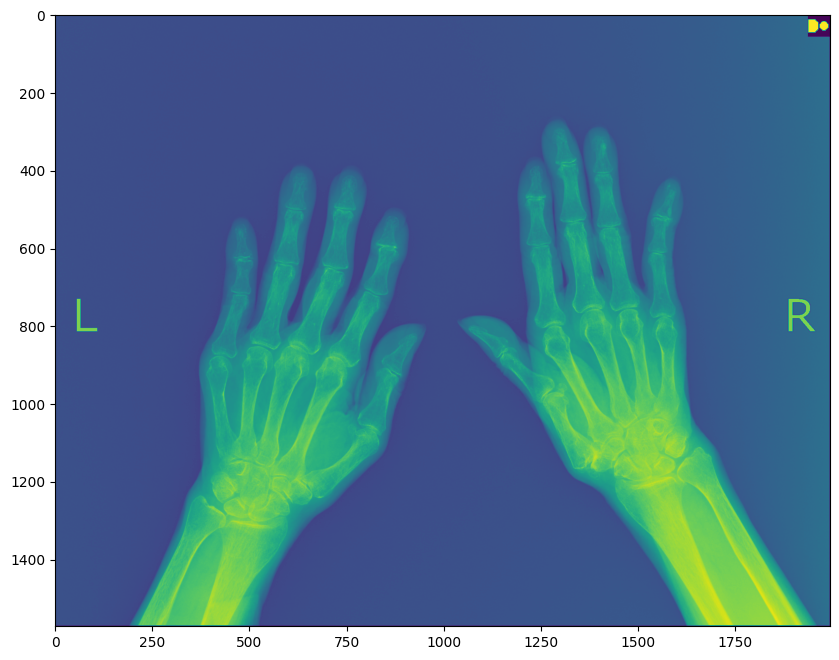

In [44]:
#ランダムに一つの画像IDを選ぶ。
img_id = imgIds[np.random.randint(0,len(imgIds))]
#選ばれた画像IDを出力。
print('Image n°{}'.format(img_id))
#選ばれた画像IDに対応する画像情報をロード。
img = coco.loadImgs(img_id)[0]
#画像のフルパスを生成
img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#画像の出力。
print('Image name: {}'.format(img_name))
#画像を読み込み、新しく図を作成して表示。
I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [45]:
#特定の画像IDとカテゴリIDに対応するアノテーションIDを取得。
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
#取得したアノテーションIDに基づいて、アノテーション情報をロード。
anns = coco.loadAnns(annIds)

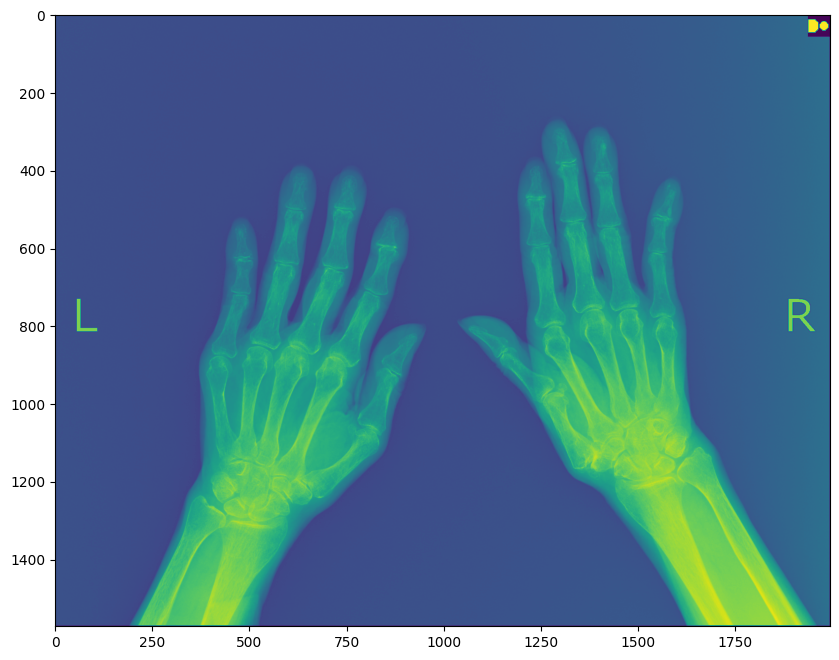

In [46]:
# load and display instance annotations
plt.imshow(I)#画像を表示
coco.showAnns(anns, draw_bbox=False)#アノテーションを画像上に表示。draw_bbox=Falseなのでここではバウンディングボックスは描画されない。

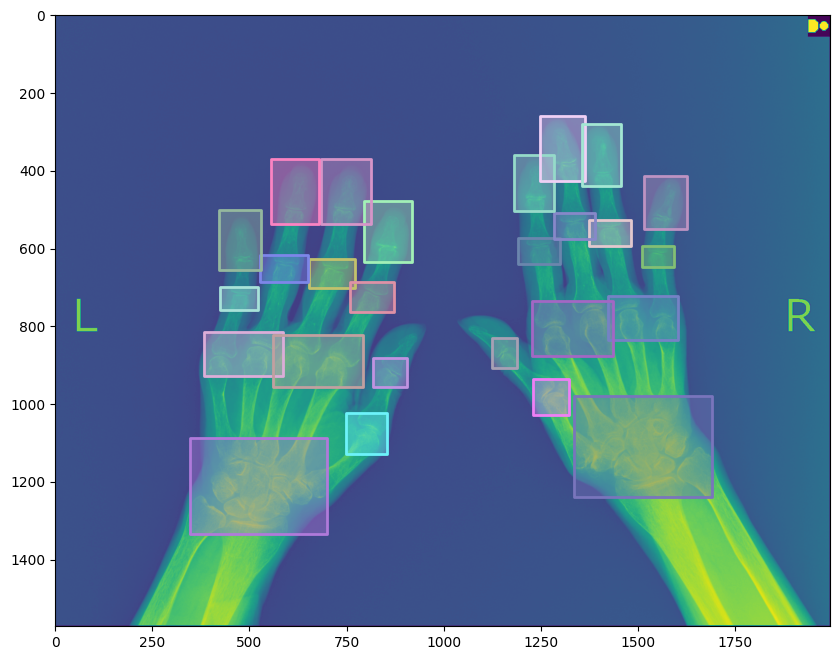

In [47]:
plt.imshow(I)#同じ画像を再度表示。
coco.showAnns(anns, draw_bbox=True)#今度はバウンディングボックスも含めてアノテーションを表示。

In [48]:
#first_class_indexが0か1であることを確認。そうでなければエラーを出力。
assert(first_class_index in [0, 1])
if first_class_index == 0:#first_class_indexが0の場合。
  num_classes = 6 #クラス数を1に設定。
  finetuned_classes = [
      'MCP1st', 'MCP', 'PIP', 'DIP', 'IP', 'Wrist',
  ]#ファインチューニングするクラスを設定。
else:#first_class_indexが1の場合。
  num_classes = 7#クラス数を2に設定。
  finetuned_classes = [
      'MCP1st', 'MCP', 'PIP', 'DIP', 'IP', 'Wrist','N/A',
  ]#ファインチューニングするクラスを'設定。

#各変数の値を出力。
print('First class index: {}'.format(first_class_index))
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 6
Fine-tuned classes: ['MCP1st', 'MCP', 'PIP', 'DIP', 'IP', 'Wrist']


In [49]:
#カレントディレクトリを/content/detr/に変更。
%cd /content/detr/

/content/detr


In [50]:
#DETRのメインスクリプトを実行。学習の設定はコマンドライン引数で指定。
!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/data/custom/" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10

Not using distributed mode
git:
  sha: 3cda3529921efb8870d0b49db7b30aa8477ae359, status: clean, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=10, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=6, dataset_file='custom', coco_path='/content/data/custom/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The param

In [51]:
#関数を用いて、学習ログを表示。具体的にはロス、mAP、各種エラー等をプロット。
from util.plot_utils import plot_logs
from pathlib import Path
log_directory = [Path('outputs/')]

/content/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


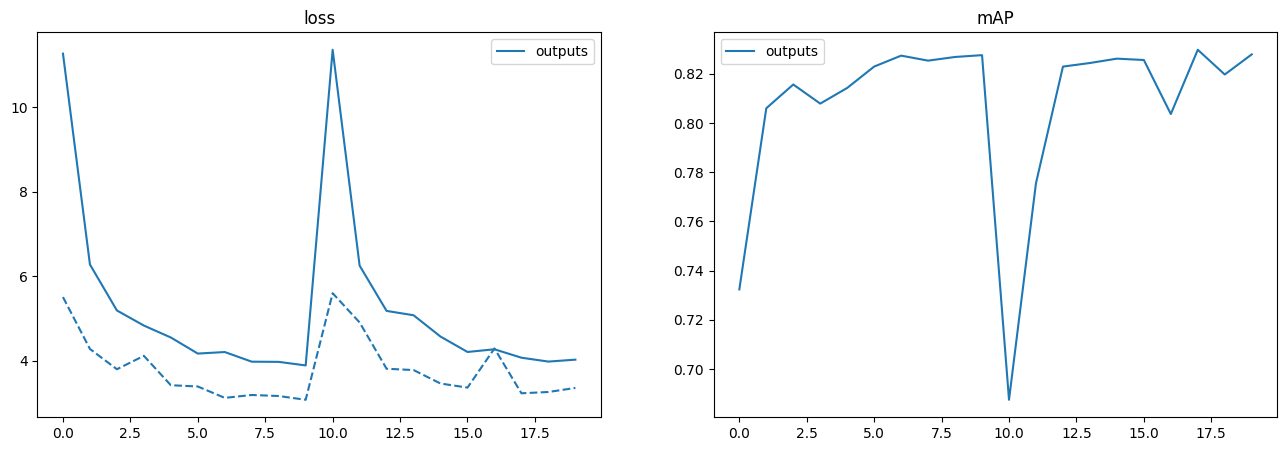

In [52]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/content/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col)

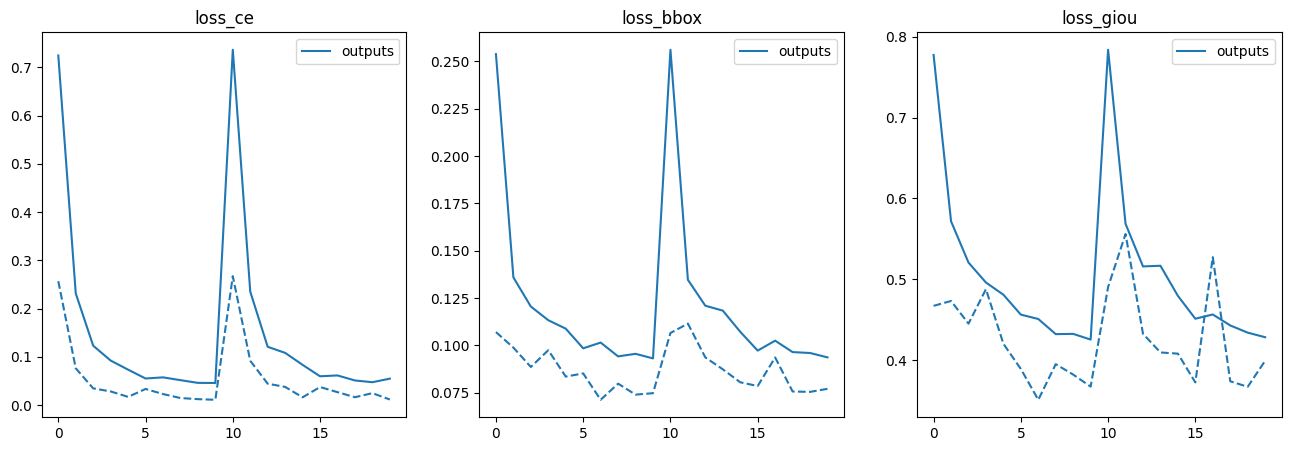

In [53]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/content/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/content/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


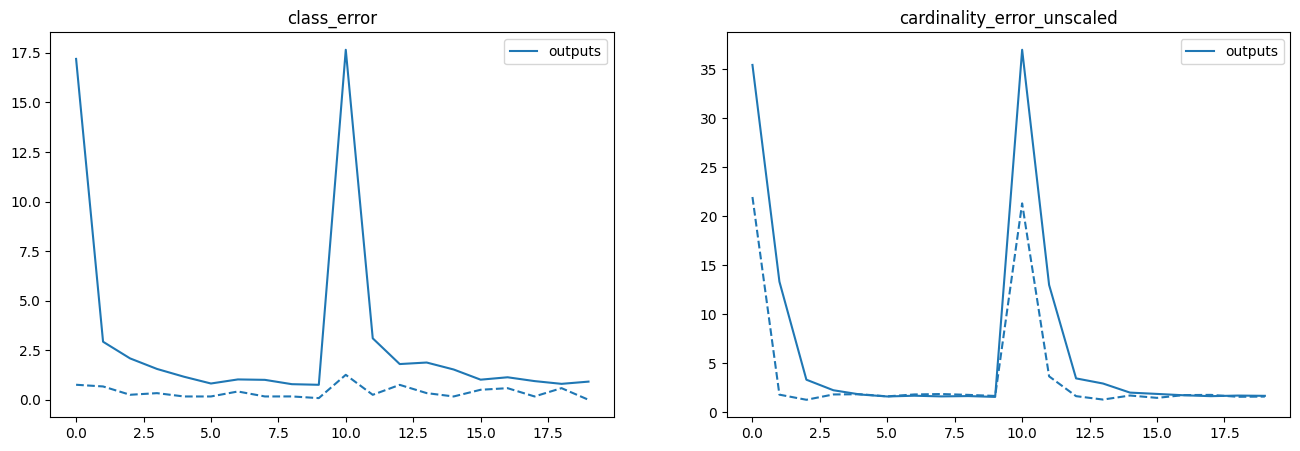

In [54]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)

In [55]:
#この行でDETRモデル（ResNet-50をバックボーンとするもの）を読み込む。このモデルは事前学習されていない（pretrained=False）ので、ランダムな重みで初期化される。
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)
#訓練が完了した後に保存されるチェックポイントファイルを読み込む。
checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')
#チェックポイントからモデルの状態を復元。strict=Falseはモデルとチェックポイントの層が完全に一致していなくても読み込むことを意味する。
model.load_state_dict(checkpoint['model'],
                      strict=False)
#モデルを評価モードに切り替え。これは、DropoutやBatch Normalizationなどの層が評価モードになることを意味する。
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#####確率とバウンディングボックスを描画する関数を宣言
関数'plot_finetuned_results'は、引数としてpil_omg, prob, bokesを使用する。

In [56]:
#指定された画像（pil_img）上に確率とバウンディングボックス（probとboxes）を描画する関数を宣言。
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    #大きさが16x11の図をプロット
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    #ボックスもプローブもない場合の処理は下の通り
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

#####推論の結果を可視化する関数を宣言
指定され画像（my_image）とモデル（my_model）を使って推論

訓練画像の表示

検証用画像の表示

In [57]:
def run_workflow(my_image, my_model):
    img = transform(my_image).unsqueeze(0)
    # グレースケール画像をRGBに変換
    if img.shape[1] == 1:
        img = img.repeat(1, 3, 1, 1)

    outputs = my_model(img)
    for threshold in [0.9, 0.7]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
        plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)

In [58]:
from torchvision import transforms

def run_workflow(my_image, my_model):
    # 画像がグレースケールの場合はRGBに変換
    if my_image.mode == 'L':
        my_image = my_image.convert('RGB')

    # 変換を適用
    img = transform(my_image).unsqueeze(0)

    outputs = my_model(img)
    for threshold in [0.9, 0.7]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
        plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)

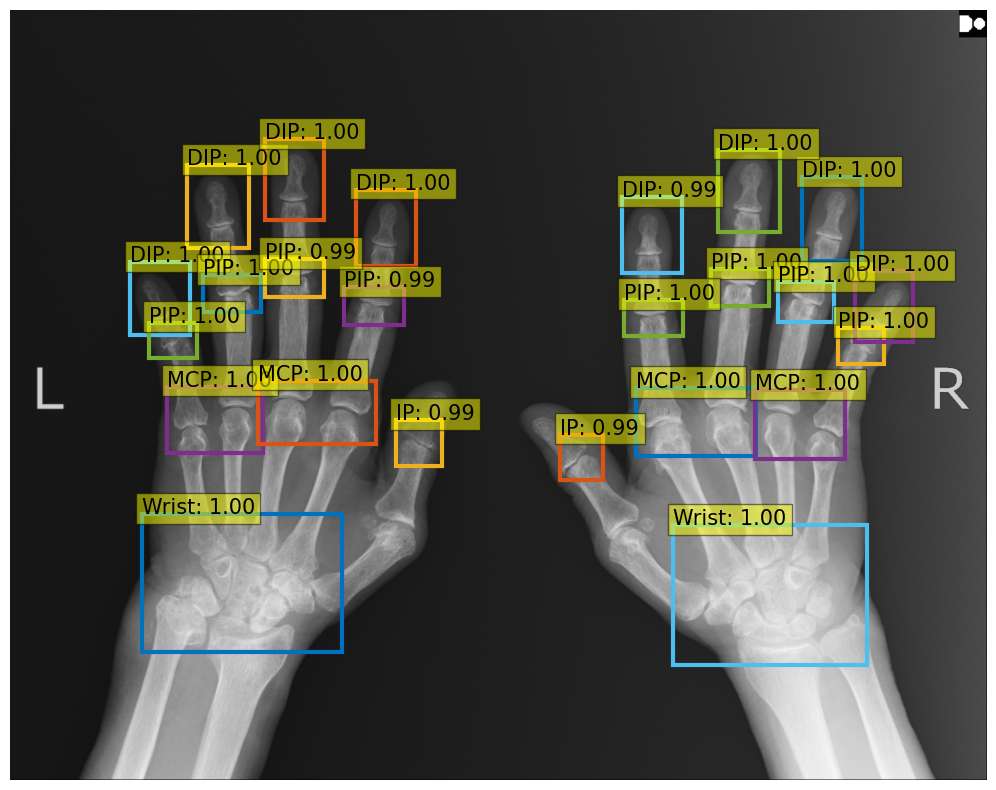

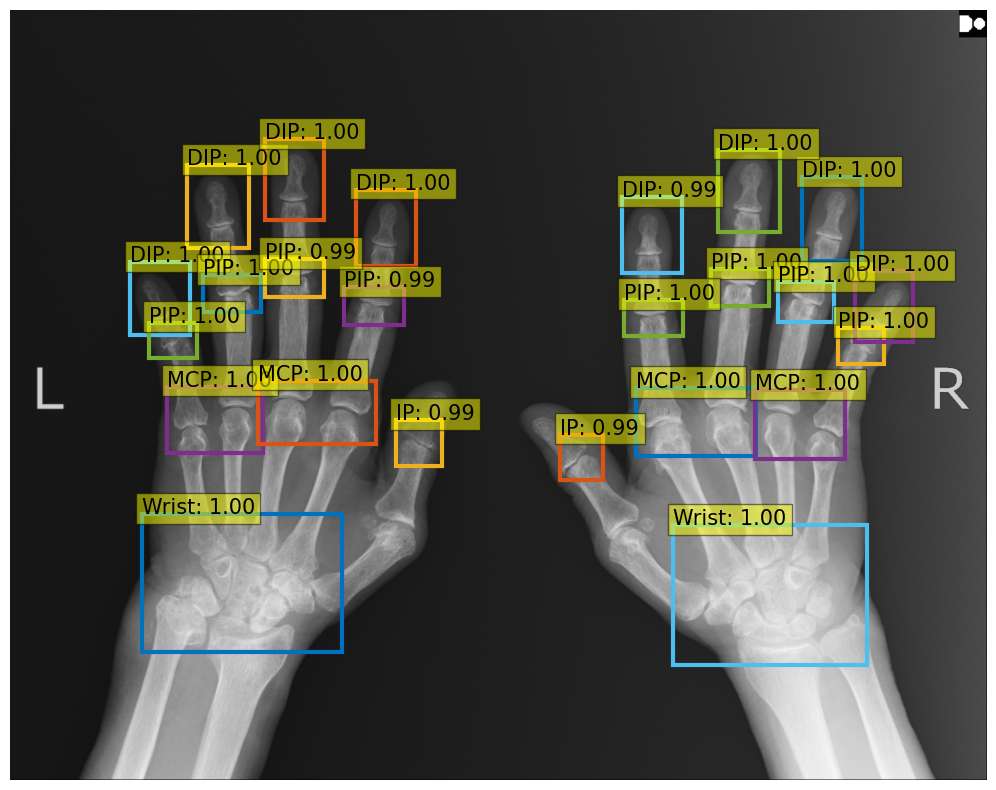

In [59]:
from PIL import Image
img_name = '/content/data/custom/train2017/010476_1.2.392.200036.9107.307.13535.1353519060616846.121.png'
im = Image.open(img_name)
run_workflow(im, model)

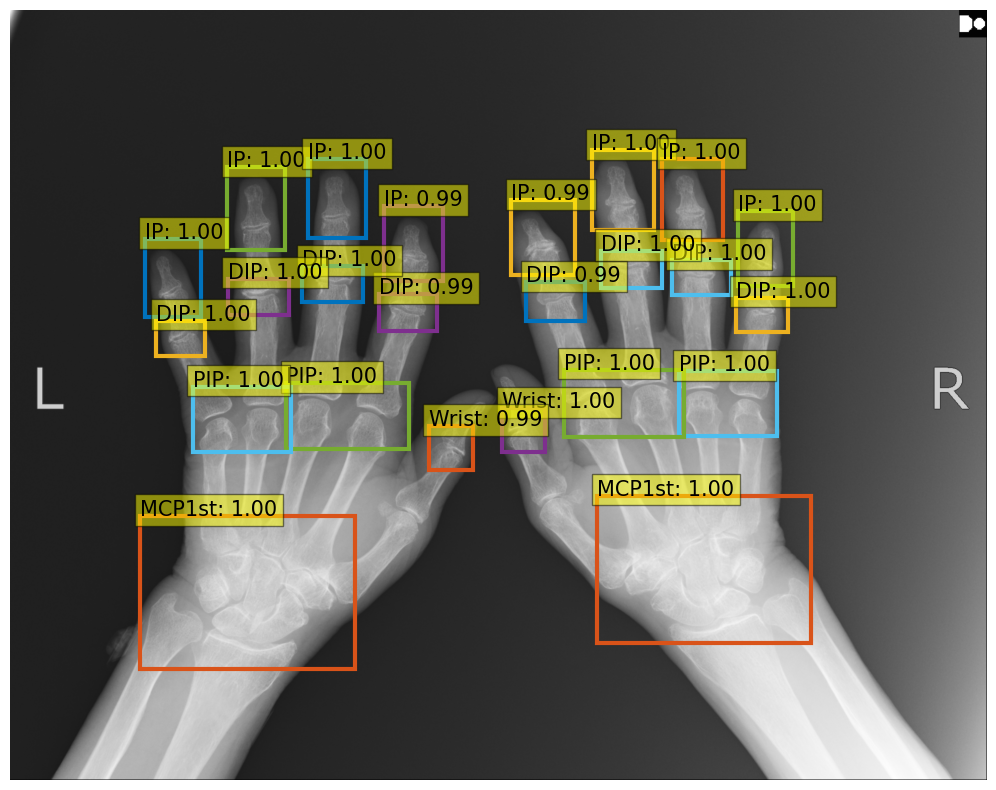

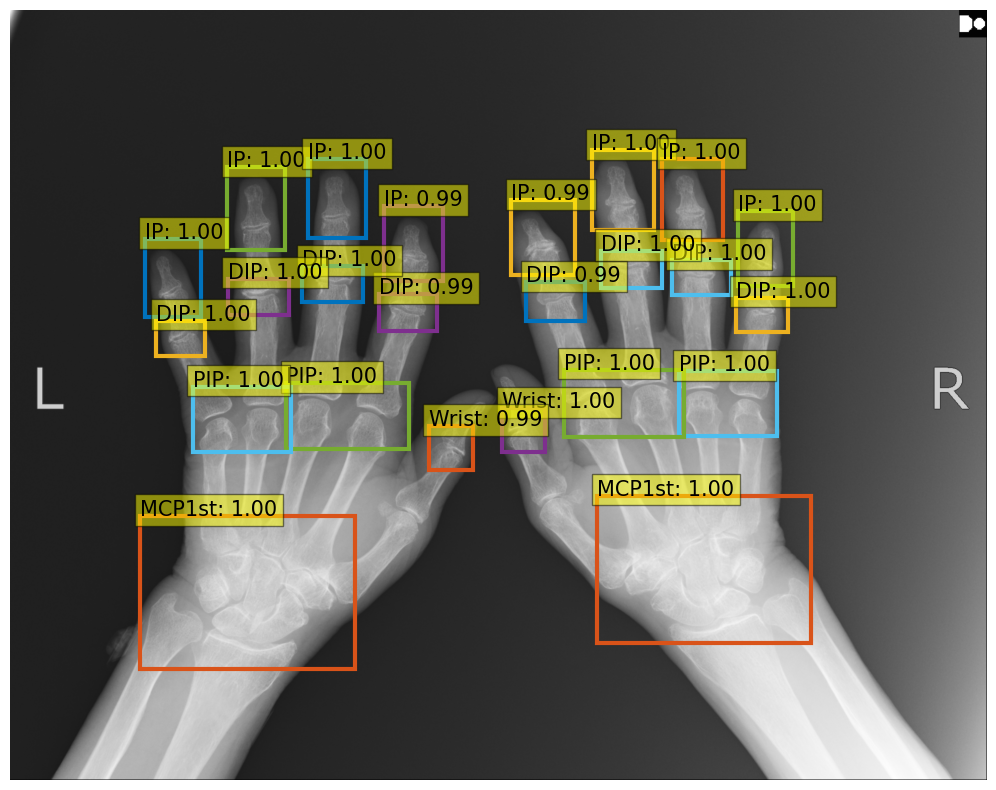

In [38]:
from PIL import Image

img_name = '/content/data/custom/val2017/014112_1.2.392.200036.9107.307.13535.1353523022029999.121.png'
im = Image.open(img_name)
run_workflow(im, model)

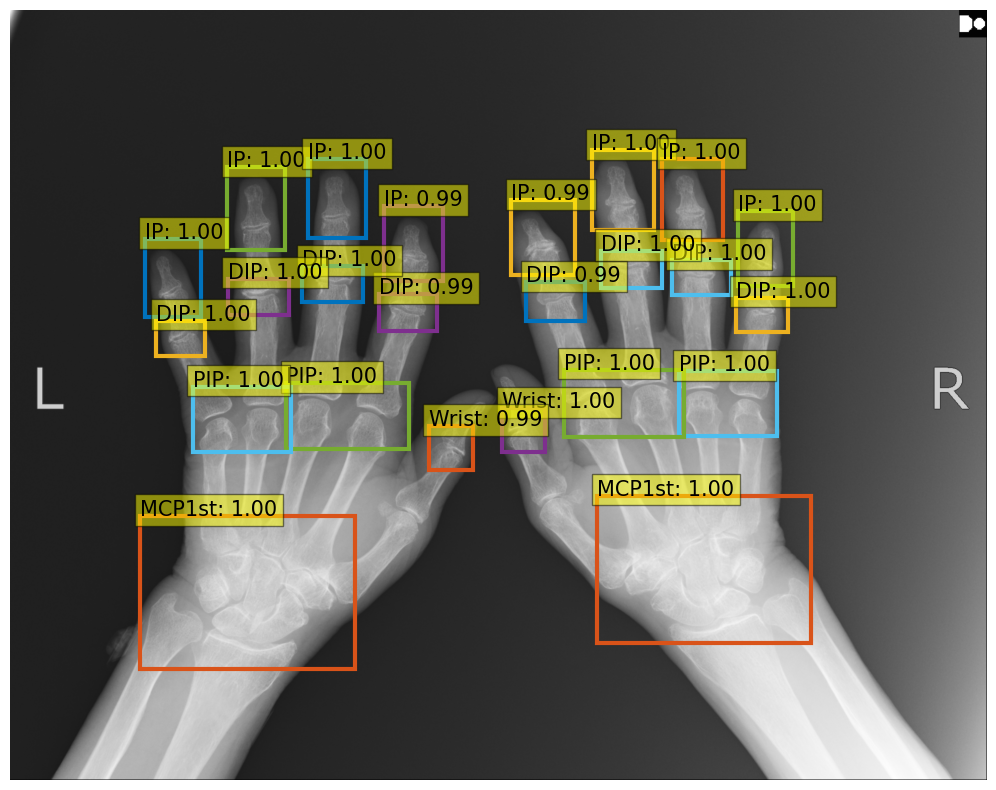

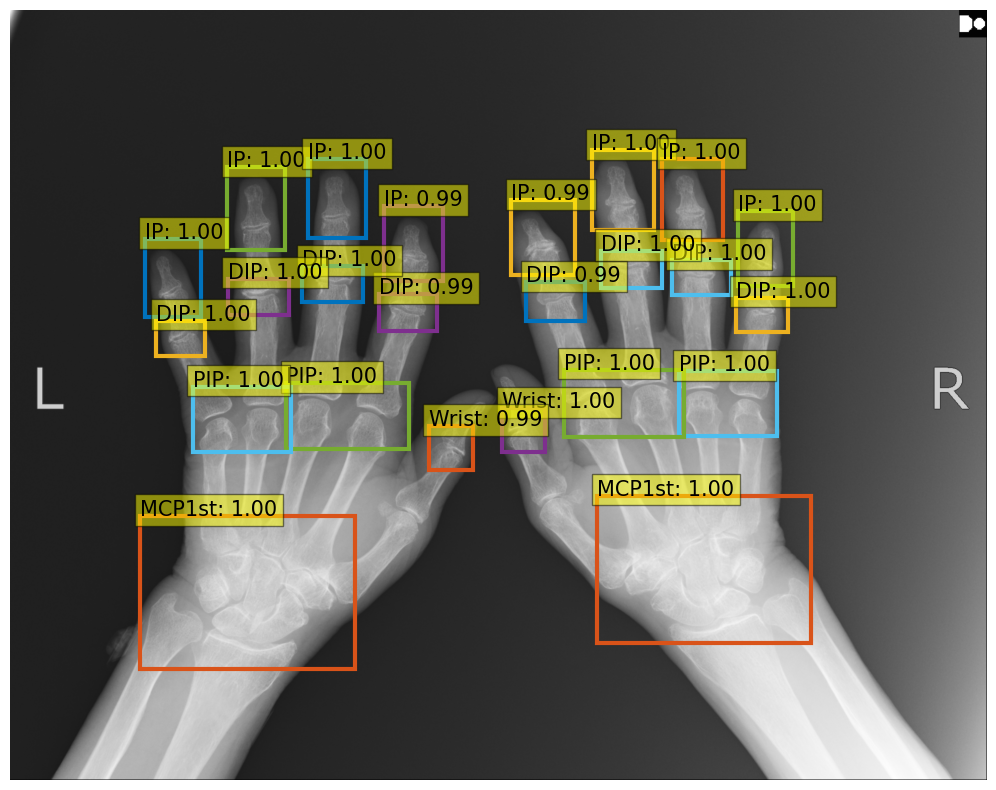

In [37]:
img_name = '/content/data/custom/val2017/014112_1.2.392.200036.9107.307.13535.1353523022029999.121.png'
im = Image.open(img_name)
run_workflow(im, model)